# Calculating Betweenness Centrality using Python

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
ox.config(use_cache=True, log_console=True)

/tmp/ipykernel_26727/2883427635.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


Download OSM data for a specific place

In [2]:
graph = ox.graph_from_place('Heidelberg, Germany', network_type='drive')

Plot the graph

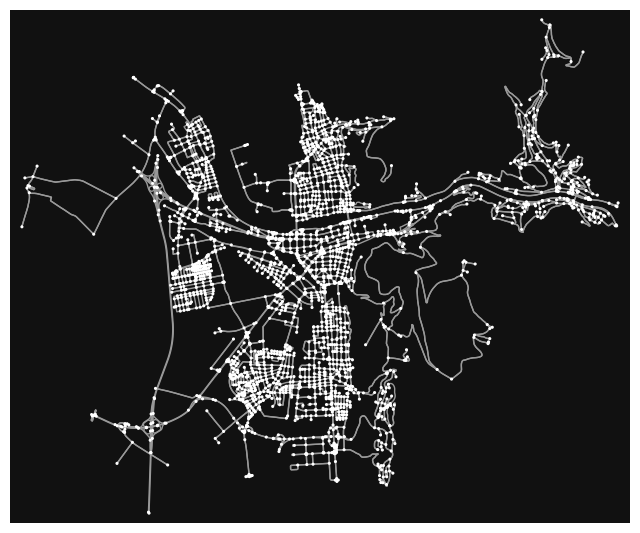

In [3]:
fig, ax = ox.plot_graph(graph, node_size=5)

### Centrality

Calculate betweenness centrality using the shortest routes (i.e. `weight='length'` means that we use the length of each edge).

In [3]:
betweenness_centrality = nx.edge_betweenness_centrality(graph, weight="length")

Convert the values in `betweenness_centrality` into a `pandas.Dataframe`.

In [5]:
centrality_df = pd.DataFrame(index=betweenness_centrality.keys(), data=betweenness_centrality.values())

Name the two index columns of the `centrality_df` 'u' and 'v'.

In [6]:
centrality_df.reset_index(inplace=True)
centrality_df.columns = ['u', 'v', 'key', 'centrality']
centrality_df = centrality_df.set_index(['u', 'v', 'key'])

Converting the graph to a `geopandas.GeoDataFrame` yields two dataframes. One for the nodes, and one for the edges.

In [7]:
nodes_df, edges_df = ox.graph_to_gdfs(graph)

Join the `centrality_df` with the `edges_df`.

In [8]:
centrality_gdf = centrality_df.join(edges_df[['osmid', 'geometry']])
centrality_gdf = gpd.GeoDataFrame(centrality_gdf, crs=4326)

In [9]:
from geopandas import geodataframe
from matplotlib import pyplot as plt
import contextily as ctx
import os

In [ ]:
%%timeit

cmap="magma_r"
column="centrality"
try:
    # Create the output folder if it doesn't exist
    if not os.path.exists("output_results"):
        os.makedirs("output_results")

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(10, 10))
    geodataframe.plot(column=column, cmap=cmap, ax=ax, legend=True)

    # Add background map using contextily
    ctx.add_basemap(
        ax,
        crs=geodataframe.crs.to_string(),
        source=ctx.providers.OpenStreetMap.Mapnik,
        zoom=15,
    )

    plt.title(f"Road Network Centrality")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Save the plot to the output folder
    output_filepath = os.path.join(
        "output_results", "road_network_centrality_plot.png"
    )
    plt.savefig(output_filepath, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Plot saved to: {output_filepath}")
    
except Exception as e:
    print(f"An error occurred: {e}")


Now that the centrality values have been joined with the edges which include the geometries, we can plot the centrality values of the road network on a map using the `geopandas.explore()` function.

In [53]:
centrality_gdf.explore(column='centrality', cmap='magma_r', tiles='cartodbpositron')

### Betweenness centrality using the fastest routes
Calculate centrality using the fastest route instead of the shortest route.


1. Assign travel speed values to each edge using the `ox.add_edge_speeds` function. **Fill in the missing road types in the dictionary below** based on the [openrouteservice documetation on travel speeds](https://giscience.github.io/openrouteservice/documentation/travel-speeds/Waytype-Speeds.html).

In [65]:
hwy_speeds = {'motorway': 130,
              'trunk': 100,
              'residential': 60,
              'tertiary': 60} #etc
graph_with_speeds = ox.add_edge_speeds(graph, hwy_speeds)

2. Calculate the travel time for each edge using the `ox.add_edge_travel_times` function.

In [ ]:
ox.add_edge_travel_times(graph_with_speeds)

3. Calculate betweenness centrality again using the `nx.edge_betweenness_centrality` but pass `weight="travel_time` as an argument.


In [ ]:
betweenness_centrality_time = nx.edge_betweenness_centrality(graph, weight="travel_time")

4. Convert the centrality value to a `pandas.DataFrame` and join it with the `edges_df` dataframe as above and visualize the result in a map.

In [ ]:
# Convert the centrality value to a `pandas.DataFrame` and join it with the `edges_df` dataframe as above and visualize the result in a map
centrality_time_df = pd.DataFrame(index=betweenness_centrality_time.keys(), data=betweenness_centrality_time.values())
centrality_time_df.reset_index(inplace=True)
centrality_time_df.columns = ['u', 'v', 'key', 'centrality']
centrality_time_df = centrality_time_df.set_index(['u', 'v', 'key'])
centrality_time_gdf = centrality_time_df.join(edges_df[['osmid', 'geometry']])
centrality_time_gdf = gpd.GeoDataFrame(centrality_time_gdf, crs=4326)


### Geographically adapted betweenness centrality

1. Get start and destination nodes in the graph from geographic coordinates using the `nearest_nodes` function.

In [ ]:
origin_node = ox.get_nearest_node(graph, (49.4097, 8.6947))

In [ ]:
destination_node = ox.get_nearest_node(graph, (49.4125, 8.6819))

2. Calculate route between the two nodes using the `ox.shortest_path()` function.

In [ ]:
route = nx.shortest_path(graph, origin_node, destination_node, weight="travel_time")

3. Plot the route using

In [ ]:
fig, ax = ox.plot_graph_route(graph, route, route_color="y", route_linewidth=6, node_size=0)

4. Convert the route to a `geopandas.GeoDataFrame` using the `ox.utils_graph.route_to_gdf`.

In [ ]:
ox.utils_graph.route_to_gdf(graph, route)

5. Generate 100 routes by choosing random start and endpoints.

6. Merge all route dataframes using the `pd.concat` function

In [ ]:
# merge all route dataframes using the pd.concat function
route_gdf = pd.concat(routes)


7. Calculate betweenness centrality indicator of the graph by grouping the routes by the columns 'u', 'v' and 'key' and counting the number of features.

In [ ]:
# Calculate betweenness centrality indicator of the graph by grouping the routes by the columns 'u', 'v' and 'key' and counting the number of features.
betweenness_centrality_geo = route_gdf.groupby(["u", "v", "key"]).size()


8. Join the dataframe containing the manually computed centrality values with the `edges_df` dataframe. Plot the manually computed betweenness centrality on an interactive map.

In [ ]:
# Join the dataframe containing the manually computed centrality values with the `edges_df` dataframe.
centrality_geo_gdf = betweenness_centrality_geo.to_frame().join(edges_df[['osmid', 'geometry']])
centrality_geo_gdf = gpd.GeoDataFrame(centrality_geo_gdf, crs=4326)
# Plot the manually computed betweenness centrality
centrality_geo_gdf.explore(column=0, cmap='magma_r', tiles='cartodbpositron')

 ### Bonus

Write a function which chooses a start and destination node from the graph based on the population distribution from the [Global Human Settlement population layer](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop).

